# Verify assembled data
Quick checks to confirm photometry (and behaviour) data extraction matches the original notebooks.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill

DATAFOLDER = Path("..//data")

# Load assembled data — change filename if needed
with open(DATAFOLDER / "assembled_data.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_behav = data["snips_behav"]
params = data["params"]

print(f"snips_photo shape: {snips_photo.shape}")
print(f"snips_behav shape: {snips_behav.shape}")
print(f"x_array shape:     {x_array.shape}")
print(f"\nColumns: {x_array.columns.tolist()}")
print(f"\nConditions: {x_array.condition.unique()}")
print(f"Infusion types: {x_array.infusiontype.unique()}")
print(f"Rats: {x_array.id.unique()}")

snips_photo shape: (1960, 200)
snips_behav shape: (1960, 200)
x_array shape:     (1960, 11)

Columns: ['trial', 'id', 'condition', 'infusiontype', 'sex', 'cluster_photo', 'clusterness_photo', 'euclidean_diff', 'auc_snips', 'auc_vel', 'time_moving']

Conditions: ['deplete' 'replete']
Infusion types: ['10NaCl' '45NaCl']
Rats: ['PB23' 'PB24' 'PB33' 'PB39' 'PB391' 'PB44' 'PB61' 'PB62' 'PB64' 'PB70'
 'PB26' 'PB27' 'PB30' 'PB31' 'PB46' 'PB48' 'PB71' 'PB72' 'PB73' 'PB75']


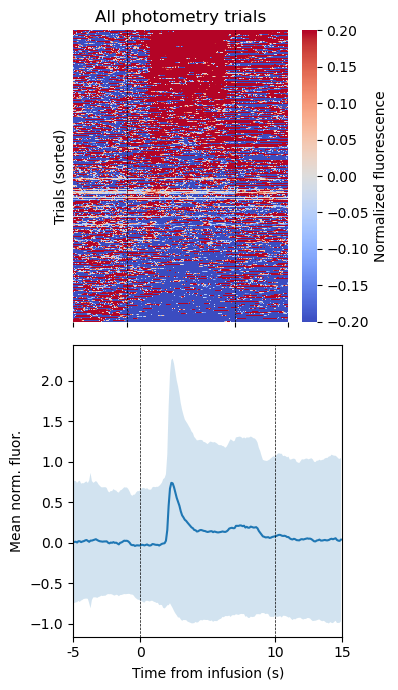

In [2]:
# ── Photometry heatmap + mean trace (matches make_tsplot from notebook) ──

framerate = 10
pre_window_size = int(params["photo_pre_seconds"] * framerate)  # 50
window_size = params["photo_bins"]  # 200
frames_for_infusion = 10 * framerate  # 100

# Sort by mean response during infusion (as in notebook)
sortwindow = [pre_window_size, pre_window_size + frames_for_infusion]
sortresponse = np.argsort(np.mean(snips_photo[:, sortwindow[0]:sortwindow[1]], axis=1))[::-1]

cmax = 0.2

f, axs = plt.subplots(nrows=2, figsize=(4, 7), sharex=True)

# Heatmap
sns.heatmap(snips_photo[sortresponse, :],
            ax=axs[0],
            cmap="coolwarm",
            vmin=-cmax, vmax=cmax,
            cbar_kws={"label": "Normalized fluorescence"})
axs[0].axvline(pre_window_size, linestyle="--", color="k", linewidth=0.5)
axs[0].axvline(pre_window_size + frames_for_infusion, linestyle="--", color="k", linewidth=0.5)
axs[0].set_ylabel("Trials (sorted)")
axs[0].set_yticks([])
axs[0].set_title("All photometry trials")

# Mean ± SD trace
mean = np.mean(snips_photo, axis=0)
sd = np.std(snips_photo, axis=0)
x = np.arange(window_size)
axs[1].fill_between(x, mean - sd, mean + sd, alpha=0.2)
axs[1].plot(x, mean)
axs[1].axvline(pre_window_size, linestyle="--", color="k", linewidth=0.5)
axs[1].axvline(pre_window_size + frames_for_infusion, linestyle="--", color="k", linewidth=0.5)
axs[1].set_ylabel("Mean norm. fluor.")

# x-axis labels in seconds
tick_positions = [0, pre_window_size, pre_window_size + frames_for_infusion, window_size]
tick_labels = [str(int((t - pre_window_size) / framerate)) for t in tick_positions]
axs[1].set_xticks(tick_positions)
axs[1].set_xticklabels(tick_labels)
axs[1].set_xlabel("Time from infusion (s)")

f.tight_layout()
plt.show()

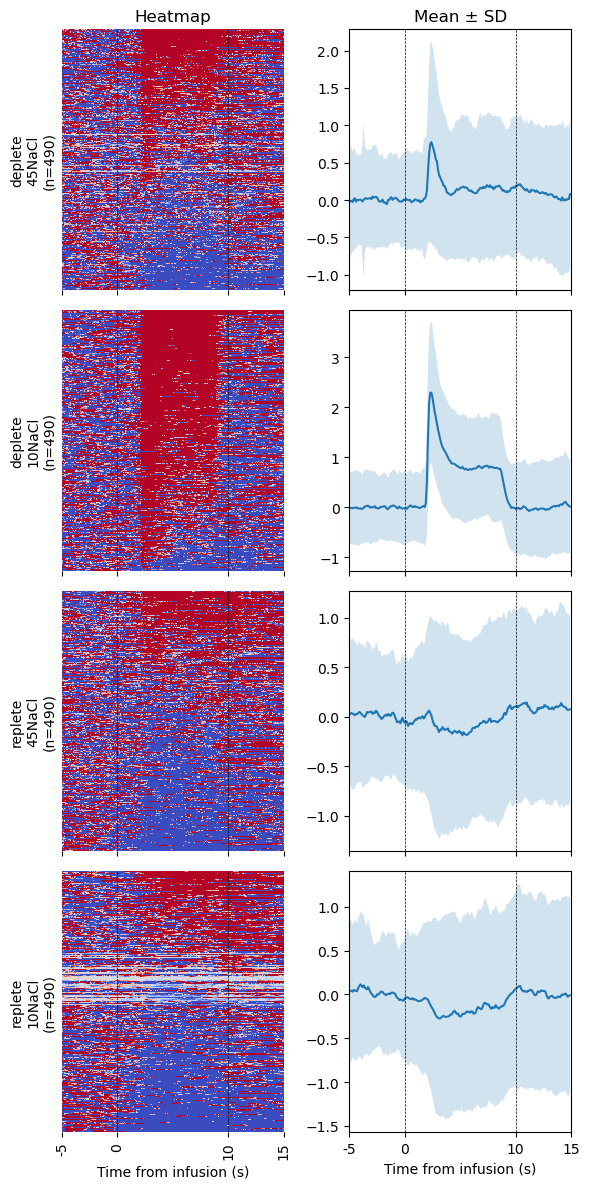

In [3]:
# ── Split by condition to check individual heatmaps ──

conditions = [("deplete", "45NaCl"), ("deplete", "10NaCl"), ("replete", "45NaCl"), ("replete", "10NaCl")]

f, axs = plt.subplots(nrows=len(conditions), ncols=2, figsize=(6, 3 * len(conditions)), sharex=True)

for i, (cond, inf) in enumerate(conditions):
    mask = (x_array.condition == cond) & (x_array.infusiontype == inf)
    subset = snips_photo[mask.values]
    
    if len(subset) == 0:
        axs[i, 0].text(0.5, 0.5, "No data", ha="center", va="center", transform=axs[i, 0].transAxes)
        axs[i, 0].set_ylabel(f"{cond}\n{inf}")
        continue
    
    sort_idx = np.argsort(np.mean(subset[:, sortwindow[0]:sortwindow[1]], axis=1))[::-1]
    
    sns.heatmap(subset[sort_idx], ax=axs[i, 0], cmap="coolwarm", vmin=-cmax, vmax=cmax, cbar=False)
    axs[i, 0].axvline(pre_window_size, linestyle="--", color="k", linewidth=0.5)
    axs[i, 0].axvline(pre_window_size + frames_for_infusion, linestyle="--", color="k", linewidth=0.5)
    axs[i, 0].set_ylabel(f"{cond}\n{inf}\n(n={len(subset)})")
    axs[i, 0].set_yticks([])
    
    mean = np.mean(subset, axis=0)
    sd = np.std(subset, axis=0)
    axs[i, 1].fill_between(x, mean - sd, mean + sd, alpha=0.2)
    axs[i, 1].plot(x, mean)
    axs[i, 1].axvline(pre_window_size, linestyle="--", color="k", linewidth=0.5)
    axs[i, 1].axvline(pre_window_size + frames_for_infusion, linestyle="--", color="k", linewidth=0.5)

for ax in axs[-1, :]:
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Time from infusion (s)")

axs[0, 0].set_title("Heatmap")
axs[0, 1].set_title("Mean ± SD")
f.tight_layout()
plt.show()

In [4]:
# ── Compare with original notebook data if available ──

original_file = DATAFOLDER / "bazzino_data.pickle"
if original_file.exists():
    with open(original_file, "rb") as f:
        orig = dill.load(f)
    
    orig_snips = orig["snips_photo"]
    orig_x = orig["x_array"]
    
    print(f"Original snips_photo shape: {orig_snips.shape}")
    print(f"New snips_photo shape:      {snips_photo.shape}")
    print(f"Original x_array shape:     {orig_x.shape}")
    print(f"New x_array shape:          {x_array.shape}")
    
    if orig_snips.shape == snips_photo.shape:
        diff = np.abs(orig_snips - snips_photo)
        print(f"\nMax absolute difference: {diff.max():.6f}")
        print(f"Mean absolute difference: {diff.mean():.6f}")
        if diff.max() < 1e-6:
            print("✓ Photometry data matches original exactly!")
        else:
            print("✗ Differences found — check extraction parameters")
    else:
        print("\nShapes differ — checking overlap by merging x_arrays...")
        common_cols = ["trial", "id", "condition", "infusiontype"]
        merged = pd.merge(
            x_array[common_cols].assign(_new_idx=np.arange(len(x_array))),
            orig_x[common_cols].reset_index(drop=True).assign(_orig_idx=np.arange(len(orig_x))),
            on=common_cols, how="inner"
        )
        print(f"  Common trials: {len(merged)}")
        print(f"  Only in new: {len(x_array) - len(merged)}")
        print(f"  Only in original: {len(orig_x) - len(merged)}")
else:
    print("No original bazzino_data.pickle found for comparison, skipping.")

Original snips_photo shape: (1960, 200)
New snips_photo shape:      (1960, 200)
Original x_array shape:     (1960, 4)
New x_array shape:          (1960, 11)

Max absolute difference: 0.000285
Mean absolute difference: 0.000008
✗ Differences found — check extraction parameters


In [5]:
# ── BEHAVIORAL DATA DIAGNOSTICS ──
# Check data processing metadata and behavioral data ranges/statistics

# Load metadata
metadata = data.get("metadata", {})

print("=" * 70)
print("DATA PROCESSING METADATA")
print("=" * 70)
if metadata:
    print(f"Behavioral metric:        {metadata.get('behav_metric', 'unknown')}")
    print(f"Behavior smoothed:        {metadata.get('behav_smoothed', False)}")
    print(f"  - Method:              {metadata.get('behav_smooth_method', 'N/A')}")
    print(f"  - Window:              {metadata.get('behav_smooth_window', 'N/A')}")
    print(f"Behavior z-scored:        {metadata.get('behav_zscored', False)}")
    print(f"Photometry smoothed:      {metadata.get('photo_smoothed', False)}")
    print(f"Photometry z-scored:      {metadata.get('photo_zscored', False)}")
else:
    print("No metadata found — data processing state unknown")

print("\n" + "=" * 70)
print("BEHAVIORAL DATA STATISTICS")
print("=" * 70)
print(f"Shape: {snips_behav.shape} (trials × timepoints)")
print(f"\nOverall range:")
print(f"  Min:  {snips_behav.min():.6f}")
print(f"  Max:  {snips_behav.max():.6f}")
print(f"  Mean: {snips_behav.mean():.6f}")
print(f"  Std:  {snips_behav.std():.6f}")
print(f"  Med:  {np.median(snips_behav):.6f}")

print(f"\nPer-trial statistics:")
trial_means = np.mean(snips_behav, axis=1)
trial_stds = np.std(snips_behav, axis=1)
print(f"  Trial means - Min: {trial_means.min():.6f}, Max: {trial_means.max():.6f}, Mean: {trial_means.mean():.6f}")
print(f"  Trial stds  - Min: {trial_stds.min():.6f}, Max: {trial_stds.max():.6f}, Mean: {trial_stds.mean():.6f}")

print(f"\nPer-timepoint statistics:")
tp_means = np.mean(snips_behav, axis=0)
tp_stds = np.std(snips_behav, axis=0)
print(f"  Timepoint means - Min: {tp_means.min():.6f}, Max: {tp_means.max():.6f}, Mean: {tp_means.mean():.6f}")
print(f"  Timepoint stds  - Min: {tp_stds.min():.6f}, Max: {tp_stds.max():.6f}, Mean: {tp_stds.mean():.6f}")

# Check for NaNs
n_nans = np.isnan(snips_behav).sum()
if n_nans > 0:
    print(f"\n⚠️  WARNING: Found {n_nans} NaN values ({100*n_nans/snips_behav.size:.2f}%)")
else:
    print(f"\n✓ No NaN values")

# Check for Infs
n_infs = np.isinf(snips_behav).sum()
if n_infs > 0:
    print(f"⚠️  WARNING: Found {n_infs} Inf values ({100*n_infs/snips_behav.size:.2f}%)")
else:
    print(f"✓ No Inf values")

DATA PROCESSING METADATA
Behavioral metric:        movement
Behavior smoothed:        True
  - Method:              gaussian
  - Window:              10
Behavior z-scored:        False
Photometry smoothed:      False
Photometry z-scored:      True

BEHAVIORAL DATA STATISTICS
Shape: (1960, 200) (trials × timepoints)

Overall range:
  Min:  0.000000
  Max:  1.000000
  Mean: 0.042864
  Std:  0.053059
  Med:  0.023711

Per-trial statistics:
  Trial means - Min: 0.001648, Max: 0.235690, Mean: 0.042864
  Trial stds  - Min: 0.000568, Max: 0.243093, Mean: 0.030951

Per-timepoint statistics:
  Timepoint means - Min: 0.038517, Max: 0.046699, Mean: 0.042864
  Timepoint stds  - Min: 0.047576, Max: 0.062302, Mean: 0.052951

✓ No NaN values
✓ No Inf values


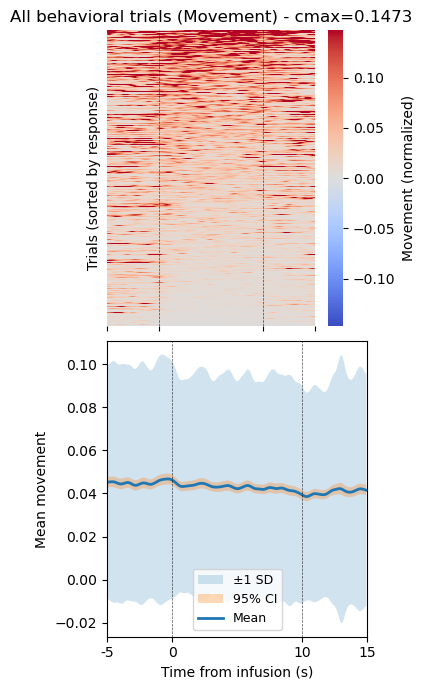

In [6]:
# ── Behavioral data heatmap + mean trace (similar to photometry) ──

framerate_behav = 10
pre_window_behav = int(params["photo_pre_seconds"] * framerate_behav)  # Should be 50
window_size_behav = params["photo_bins"]  # Should be 200
frames_for_infusion_behav = 10 * framerate_behav  # 100

# Sort by response during infusion window
sortwindow_behav = [pre_window_behav, pre_window_behav + frames_for_infusion_behav]
sortresponse_behav = np.argsort(np.mean(snips_behav[:, sortwindow_behav[0]:sortwindow_behav[1]], axis=1))[::-1]

# Use appropriate colormap limits based on data range
cmax_behav = np.percentile(np.abs(snips_behav), 95)  # 95th percentile for scaling

f, axs = plt.subplots(nrows=2, figsize=(4, 7), sharex=True)

# Heatmap
sns.heatmap(snips_behav[sortresponse_behav, :],
            ax=axs[0],
            cmap="coolwarm",
            vmin=-cmax_behav, vmax=cmax_behav,
            cbar_kws={"label": "Movement (normalized)"},
            robust=True)
axs[0].axvline(pre_window_behav, linestyle="--", color="k", linewidth=0.5, alpha=0.7)
axs[0].axvline(pre_window_behav + frames_for_infusion_behav, linestyle="--", color="k", linewidth=0.5, alpha=0.7)
axs[0].set_ylabel("Trials (sorted by response)")
axs[0].set_yticks([])
axs[0].set_title(f"All behavioral trials (Movement) - cmax={cmax_behav:.4f}")

# Mean ± SD trace
mean_behav = np.mean(snips_behav, axis=0)
sd_behav = np.std(snips_behav, axis=0)
sem_behav = sd_behav / np.sqrt(len(snips_behav))
x_behav = np.arange(window_size_behav)

axs[1].fill_between(x_behav, mean_behav - sd_behav, mean_behav + sd_behav, alpha=0.2, label="±1 SD")
axs[1].fill_between(x_behav, mean_behav - 1.96*sem_behav, mean_behav + 1.96*sem_behav, alpha=0.3, label="95% CI")
axs[1].plot(x_behav, mean_behav, linewidth=2, label="Mean")
axs[1].axvline(pre_window_behav, linestyle="--", color="k", linewidth=0.5, alpha=0.7)
axs[1].axvline(pre_window_behav + frames_for_infusion_behav, linestyle="--", color="k", linewidth=0.5, alpha=0.7)
axs[1].set_ylabel("Mean movement")
axs[1].legend(loc="best", fontsize=9)

# x-axis labels in seconds
tick_positions = [0, pre_window_behav, pre_window_behav + frames_for_infusion_behav, window_size_behav]
tick_labels = [str(int((t - pre_window_behav) / framerate_behav)) for t in tick_positions]
axs[1].set_xticks(tick_positions)
axs[1].set_xticklabels(tick_labels)
axs[1].set_xlabel("Time from infusion (s)")

f.tight_layout()
plt.show()

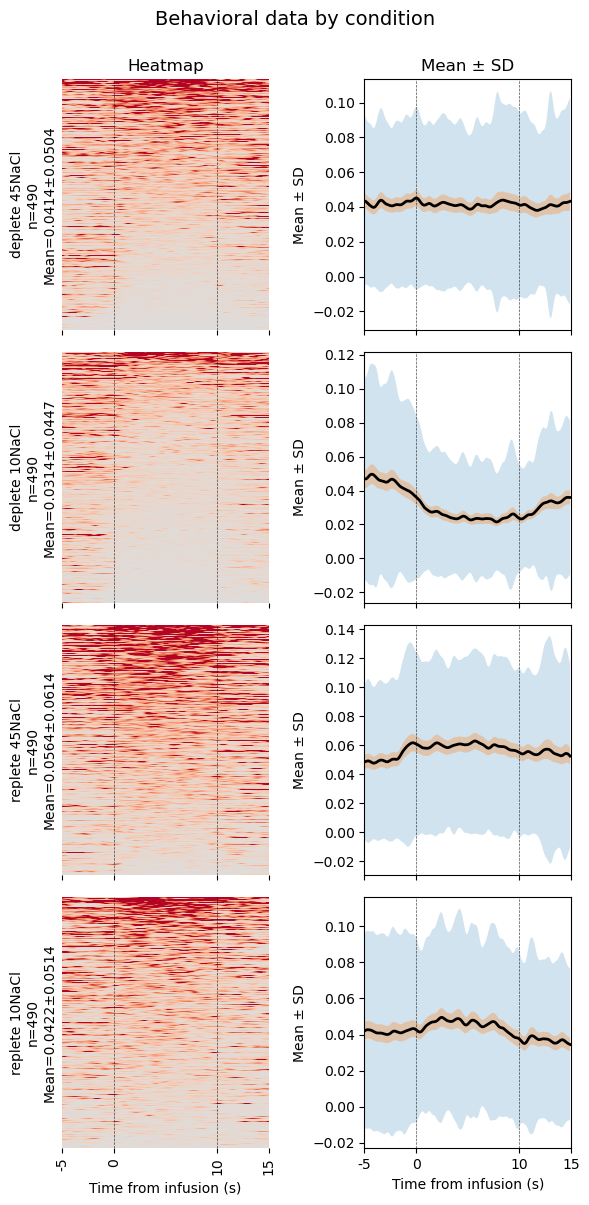


Behavioral data summary by condition:

deplete  45NaCl  (n=490): range=[0.0000, 1.0000], mean=0.0414±0.0504

deplete  10NaCl  (n=490): range=[0.0000, 0.9189], mean=0.0314±0.0447

replete  45NaCl  (n=490): range=[0.0000, 0.9247], mean=0.0564±0.0614

replete  10NaCl  (n=490): range=[0.0000, 0.8634], mean=0.0422±0.0514


In [7]:
# ── Split behavioral data by condition to check individual patterns ──

conditions = [("deplete", "45NaCl"), ("deplete", "10NaCl"), ("replete", "45NaCl"), ("replete", "10NaCl")]

f, axs = plt.subplots(nrows=len(conditions), ncols=2, figsize=(6, 3 * len(conditions)), sharex=True)

for i, (cond, inf) in enumerate(conditions):
    mask = (x_array.condition == cond) & (x_array.infusiontype == inf)
    subset = snips_behav[mask.values]
    
    if len(subset) == 0:
        axs[i, 0].text(0.5, 0.5, "No data", ha="center", va="center", 
                       transform=axs[i, 0].transAxes, fontsize=12)
        axs[i, 0].set_ylabel(f"{cond}\n{inf}")
        axs[i, 1].text(0.5, 0.5, "No data", ha="center", va="center", 
                       transform=axs[i, 1].transAxes, fontsize=12)
        continue
    
    # Statistics for this condition
    cond_mean = subset.mean()
    cond_std = subset.std()
    cond_min = subset.min()
    cond_max = subset.max()
    
    sort_idx = np.argsort(np.mean(subset[:, sortwindow_behav[0]:sortwindow_behav[1]], axis=1))[::-1]
    
    # Heatmap
    sns.heatmap(subset[sort_idx], ax=axs[i, 0], cmap="coolwarm", 
                vmin=-cmax_behav, vmax=cmax_behav, cbar=False, robust=True)
    axs[i, 0].axvline(pre_window_behav, linestyle="--", color="k", linewidth=0.5, alpha=0.7)
    axs[i, 0].axvline(pre_window_behav + frames_for_infusion_behav, linestyle="--", color="k", linewidth=0.5, alpha=0.7)
    axs[i, 0].set_ylabel(f"{cond} {inf}\nn={len(subset)}\nMean={cond_mean:.4f}±{cond_std:.4f}")
    axs[i, 0].set_yticks([])
    
    # Mean ± SD trace
    mean_subset = np.mean(subset, axis=0)
    sd_subset = np.std(subset, axis=0)
    sem_subset = sd_subset / np.sqrt(len(subset))
    axs[i, 1].fill_between(x_behav, mean_subset - sd_subset, mean_subset + sd_subset, alpha=0.2)
    axs[i, 1].fill_between(x_behav, mean_subset - 1.96*sem_subset, mean_subset + 1.96*sem_subset, alpha=0.3)
    axs[i, 1].plot(x_behav, mean_subset, linewidth=2, color="k")
    axs[i, 1].axvline(pre_window_behav, linestyle="--", color="k", linewidth=0.5, alpha=0.7)
    axs[i, 1].axvline(pre_window_behav + frames_for_infusion_behav, linestyle="--", color="k", linewidth=0.5, alpha=0.7)
    axs[i, 1].set_ylabel("Mean ± SD")

for ax in axs[-1, :]:
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Time from infusion (s)")

axs[0, 0].set_title("Heatmap")
axs[0, 1].set_title("Mean ± SD")
f.suptitle("Behavioral data by condition", fontsize=14, y=1.00)
f.tight_layout()
plt.show()

print("\nBehavioral data summary by condition:")
for cond, inf in conditions:
    mask = (x_array.condition == cond) & (x_array.infusiontype == inf)
    subset = snips_behav[mask.values]
    if len(subset) > 0:
        print(f"\n{cond:8} {inf:7} (n={len(subset):3}): "
              f"range=[{subset.min():.4f}, {subset.max():.4f}], "
              f"mean={subset.mean():.4f}±{subset.std():.4f}")

In [8]:
# ── Compare behavioral data between conditions and check scaling consistency ──

print("=" * 70)
print("BEHAVIORAL vs PHOTOMETRY COMPARISON")
print("=" * 70)

print(f"\nBehavioral data range:    [{snips_behav.min():.6f}, {snips_behav.max():.6f}]")
print(f"Photometry data range:    [{snips_photo.min():.6f}, {snips_photo.max():.6f}]")
print(f"\nBehavioral data mean±std: {snips_behav.mean():.6f} ± {snips_behav.std():.6f}")
print(f"Photometry data mean±std: {snips_photo.mean():.6f} ± {snips_photo.std():.6f}")

# Check consistency across animals
print("\n" + "=" * 70)
print("BEHAVIORAL DATA BY ANIMAL")
print("=" * 70)

animal_stats = []
for animal_id in sorted(x_array.id.unique()):
    mask = x_array.id == animal_id
    subset = snips_behav[mask.values]
    if len(subset) > 0:
        animal_stats.append({
            'id': animal_id,
            'n_trials': len(subset),
            'min': subset.min(),
            'max': subset.max(),
            'mean': subset.mean(),
            'std': subset.std()
        })

stats_df = pd.DataFrame(animal_stats)
print(stats_df.to_string(index=False))

# Check for outliers or anomalies
print("\n" + "=" * 70)
print("CHECKING FOR ANOMALIES")
print("=" * 70)

# Trials with unusually low/high variance
trial_vars = np.var(snips_behav, axis=1)
low_var_trials = np.where(trial_vars < np.percentile(trial_vars, 5))[0]
high_var_trials = np.where(trial_vars > np.percentile(trial_vars, 95))[0]

if len(low_var_trials) > 0:
    print(f"⚠️  {len(low_var_trials)} trials with very low variance (< 5th percentile)")
    print(f"   Example: {low_var_trials[:5]}")
if len(high_var_trials) > 0:
    print(f"⚠️  {len(high_var_trials)} trials with very high variance (> 95th percentile)")
    print(f"   Example: {high_var_trials[:5]}")

# Check response during infusion window
infusion_responses = np.mean(snips_behav[:, sortwindow_behav[0]:sortwindow_behav[1]], axis=1)
print(f"\nResponse during infusion window:")
print(f"  Min:  {infusion_responses.min():.6f}")
print(f"  Max:  {infusion_responses.max():.6f}")
print(f"  Mean: {infusion_responses.mean():.6f}±{infusion_responses.std():.6f}")

# Check baseline (pre-infusion)
baseline = np.mean(snips_behav[:, :pre_window_behav], axis=1)
print(f"\nBaseline (pre-infusion):")
print(f"  Min:  {baseline.min():.6f}")
print(f"  Max:  {baseline.max():.6f}")
print(f"  Mean: {baseline.mean():.6f}±{baseline.std():.6f}")

BEHAVIORAL vs PHOTOMETRY COMPARISON

Behavioral data range:    [0.000000, 1.000000]
Photometry data range:    [-18.033354, 9.586558]

Behavioral data mean±std: 0.042864 ± 0.053059
Photometry data mean±std: 0.098376 ± 0.976880

BEHAVIORAL DATA BY ANIMAL
   id  n_trials      min      max     mean      std
 PB23        98 0.000000 0.547511 0.045960 0.051268
 PB24        98 0.000000 0.479165 0.032909 0.038073
 PB26        98 0.000000 0.325014 0.034104 0.038058
 PB27        98 0.000000 0.425183 0.044320 0.045141
 PB30        98 0.000000 0.522872 0.036380 0.040423
 PB31        98 0.000054 0.924741 0.057879 0.066472
 PB33        98 0.000000 0.918894 0.038202 0.044759
 PB39        98 0.000000 0.805573 0.031501 0.044842
PB391        98 0.000000 0.863386 0.033078 0.048901
 PB44        98 0.000492 0.608912 0.042643 0.053298
 PB46        98 0.000991 0.501820 0.074152 0.068522
 PB48        98 0.000000 0.829833 0.045879 0.058974
 PB61        98 0.000245 0.649974 0.042738 0.057609
 PB62        98 0.0

In [ ]:
# ── Compare behavioral data with original if available ──

if original_file.exists():
    print("\n" + "=" * 70)
    print("BEHAVIORAL DATA COMPARISON WITH ORIGINAL")
    print("=" * 70)
    
    original_snips_behav = orig.get("snips_behav", None)
    if original_snips_behav is not None:
        print(f"Original snips_behav shape: {original_snips_behav.shape}")
        print(f"New snips_behav shape:      {snips_behav.shape}")
        
        if original_snips_behav.shape == snips_behav.shape:
            behav_diff = np.abs(original_snips_behav - snips_behav)
            print(f"\nMax absolute difference:  {behav_diff.max():.6f}")
            print(f"Mean absolute difference: {behav_diff.mean():.6f}")
            print(f"Median absolute difference: {np.median(behav_diff):.6f}")
            
            if behav_diff.max() < 1e-6:
                print("✓ Behavioral data matches original exactly!")
            else:
                print("✗ Behavioral data differs from original")
                print(f"  This may be due to re-processing. Check params and scaling.")
                
                # Show which trials differ most
                max_diffs_per_trial = behav_diff.max(axis=1)
                worst_trials = np.argsort(max_diffs_per_trial)[-5:][::-1]
                print(f"\n  Trials with largest differences:")
                for trial_idx in worst_trials:
                    print(f"    Trial {trial_idx}: max diff = {max_diffs_per_trial[trial_idx]:.6f}")
        else:
            print(f"\n⚠️  Shapes differ — data may have been reprocessed")
            print(f"  Original: {original_snips_behav.shape}")
            print(f"  New:      {snips_behav.shape}")
    else:
        print("No behav data in original pickle")
else:
    print("\n(No original bazzino_data.pickle found for behavior comparison)")

In [ ]:
# ── Visual inspection of example trials ──
# Display individual trial timeseries to visually check quality

n_examples = 4
fig, axes = plt.subplots(n_examples, len(conditions), figsize=(12, 2*n_examples))

for col, (cond, inf) in enumerate(conditions):
    mask = (x_array.condition == cond) & (x_array.infusiontype == inf)
    trials_idx = np.where(mask.values)[0]
    
    if len(trials_idx) == 0:
        axes[0, col].text(0.5, 0.5, "No data", ha="center", va="center")
        continue
    
    # Select diverse examples (low, medium, high response)
    if len(trials_idx) >= n_examples:
        response_strength = np.mean(snips_behav[trials_idx, sortwindow_behav[0]:sortwindow_behav[1]], axis=1)
        sorted_idx = np.argsort(response_strength)
        example_indices = [
            trials_idx[sorted_idx[0]],  # Lowest response
            trials_idx[sorted_idx[len(sorted_idx)//3]],  # Low-mid
            trials_idx[sorted_idx[2*len(sorted_idx)//3]],  # Mid-high
            trials_idx[sorted_idx[-1]],  # Highest response
        ]
    else:
        example_indices = trials_idx[:n_examples]
    
    for row, trial_idx in enumerate(example_indices):
        ax = axes[row, col]
        trial_data = snips_behav[trial_idx, :]
        response = np.mean(trial_data[sortwindow_behav[0]:sortwindow_behav[1]])
        
        ax.plot(x_behav, trial_data, linewidth=1.5, color="steelblue")
        ax.axvline(pre_window_behav, linestyle="--", color="r", linewidth=0.8, alpha=0.5, label="Infusion start")
        ax.axvline(pre_window_behav + frames_for_infusion_behav, linestyle="--", color="r", linewidth=0.8, alpha=0.5)
        ax.axhline(0, linestyle=":", color="gray", linewidth=0.5, alpha=0.5)
        ax.set_ylabel(f"Movement", fontsize=9)
        ax.set_ylim([snips_behav.min() * 1.1, snips_behav.max() * 1.1])
        
        # Title with response strength
        if row == 0:
            ax.set_title(f"{cond} {inf}", fontsize=10, fontweight="bold")
        ax.text(0.02, 0.98, f"Trial {trial_idx}\nResp: {response:.4f}", 
                transform=ax.transAxes, fontsize=8, va="top", ha="left",
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

for ax in axes[-1, :]:
    ax.set_xlabel("Time from infusion (s)")
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

fig.suptitle("Example individual behavioral trials (showing range from low to high response)", 
             fontsize=12, fontweight="bold")
fig.tight_layout()
plt.show()